   Location ID  X_Coordinate  Y_Coordinate  Demand  Ready Time  Due Date  \
0            0            40            50       0           0      1236   
1            1            42            66      20          65       146   
2            2            42            65      20          15        67   
3            3            40            69      20         621       702   
4            4            38            68      20         255       324   
5            5            38            70      10         534       605   
6            6            41            51      30         448       505   

   Service Time  
0             0  
1            90  
2            90  
3            90  
4            90  
5            90  
6            90  
Restricted license - for non-production use only - expires 2023-10-25
Set parameter MIPGap to value 0
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a mod

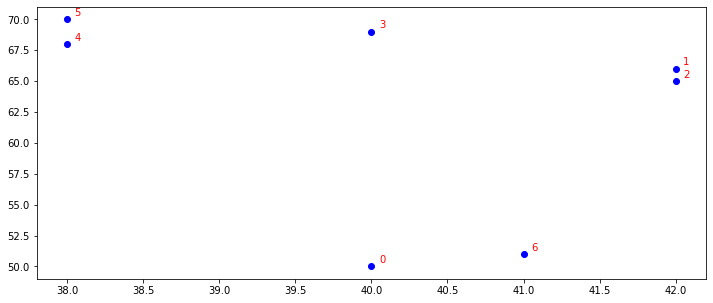

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Dec  8 14:08:24 2022

@author: maxcrebolder
"""
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *
import numpy as np
import itertools


df = pd.read_csv('data_small.txt', sep = "\t", names =  ['0', '1', '2', '3', '4', '5', '6'])

#print(pd.DataFrame(df))

# read data_large.text and data_small.text
import seaborn as sns

# read data_large.text and data_small.text
data_large = pd.read_csv('data_large.txt', sep='\t', names=['Location ID', 'X_Coordinate', 'Y_Coordinate', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])
data_small = pd.read_csv('data_small.txt', sep='\t', names=['Location ID', 'X_Coordinate', 'Y_Coordinate', 'Demand', 'Ready Time', 'Due Date', 'Service Time'])

# show the entire data
#print(data_large)
print(data_small)


# first collum is location_ID
LOC_ID = (data_small.iloc[:,0])

# second collum is X_coordinate
X_COORD = (data_small.iloc[:,1])

# third collum is Y_coordinate
Y_COORD = (data_small.iloc[:,2])

# fourth collum is demand at the location
D = (data_small.iloc[:,3])

# fifth collum is ready time at the location
RT = (data_small.iloc[:,4])

# sixth collum is due time at the location
DT = (data_small.iloc[:,5])

# seventh collum is service time at the location
ST = (data_small.iloc[:,6])

M = 10000     # Large integer for 



c_matrix = np.zeros([len(LOC_ID), len(LOC_ID)])
for i in range(len(LOC_ID)):
    for j in range(len(LOC_ID)):
                if i == j:
                    c_matrix[i][j] = M
                else:
                    c_matrix[i][j] = np.sqrt((X_COORD[j] - X_COORD[i])** 2 + (Y_COORD[j] - Y_COORD[i])** 2)

#print(c_matrix)

N = 7 

model = Model ('Assignment_2b')

# ---- Sets ----

I = range (len(LOC_ID))                # set of Nodes
J = range (len(LOC_ID))                   # set of edges


# ---- Variables ----

# Decision Variable x(i,j) (Travelled between node i and node j)

x = {} 
for i in I:
    for j in J:
        x[i,j] = model.addVar(vtype = GRB.BINARY, name = 'x[' + str(j) + ']')

# Decision Variable z(j) (Distance travelled between node i and node j)

z = {} 
for j in J:
    z[j] = model.addVar(vtype = GRB.CONTINUOUS, name = 'z[' + str(j) + ']')
    
t = {}
for i in I:
    t[i]= model.addVar(vtype = GRB.CONTINUOUS, name  = 't[' + str(i) + ',' + str(j) + ']')
for j in J:
    t[j] = model.addVar(vtype = GRB.CONTINUOUS, name  = 't[' + str(i) + ',' + str(j) + ']')
u = {}
for i in I:
    for j in J:
        u[i,j] = model.addVar(vtype = GRB.CONTINUOUS, name  = 'u[' + str(i) + ',' + str(j) + ']')
        
# Integrate new variables
model.update ()


# ---- Objective Function ----

model.setObjective(quicksum((c_matrix[i,j] * x[i,j]) for i in I for j in J))
model.modelSense = GRB.MINIMIZE
model.update ()


# ---- Constraints ----
def findsubsets(s,n):
    return list(itertools.combinations(s,n))

s = {0,1,2,3,4,5,6}
n = 2

#print(findsubsets(s,n))
# Contraint 1: distance between the nodes
con1 ={}
con2 = {}
for i in I: 
    for j in J: 
        if i != j:
            con1[j] = model.addConstr(quicksum(x[i,j] for i in I) == 2)
            con2[i]= model.addConstr(quicksum(x[i,j] for j in J) == 2)

        
# Contraint 2: symmetry
#con3 ={}
for i in I:
    for j in J:
        x[i,j] = x[j,i]


# Contraint 3: subtour elimenation
con3 ={}
for i in I:
    for j in J:
        if i != j:
            con3[i,j] = model.addConstr(quicksum(x[i,j] for i,j in findsubsets(s,n)) <= (N-1))

# Constraint starting time depot

con4 ={}
for j in J:
    for i in I:
        con4[j]= model.addConstr(RT[i] + c_matrix[i,j] - M*(1-x[i,j]) <= t[j])

# Constraint arrival time vehicle 
con5 ={}
for i in I:
    for j in J:
        con5[i,j] = model.addConstr(t[i] + c_matrix[i,j] + ST[i] - M*(1-x[i,j]) <= t[j])

# Constraint arrival time after opening time
con6 ={}
for j in J:
    con6 = model.addConstr(t[i] >= RT[j])

# Constraint before due time
con7 ={}
con7[i,j] = model.addConstr(t[i] <= DT[j])

# Constraint time > 0
con8 = {}
for i in I:
    con8[i] = model.addConstr(t[i] >= 0)
# ---- Solve ----

model.setParam('OutputFlag', True) # silencing gurobi output or not
model.setParam ('MIPGap', 0);       # find the optimal solution
model.write("output.lp")            # print the model in .lp format file

model.optimize ()


plt.figure(figsize = (12, 5))
for i in range(len(LOC_ID)):
    plt.scatter(X_COORD[i], Y_COORD[i], color = 'blue') 
    plt.annotate(str(LOC_ID[i]), xy = (X_COORD[i], Y_COORD[i]), xytext = (X_COORD[i] + 0.05, Y_COORD[i] + 0.3), color = 'red')

if model.status == GRB.Status.OPTIMAL: # If optimal solution is found
    print('all decision variables:\n')
    # number of workers
    for j in J:
        r ='%8s' % 'x[i,j]'
    for i in I:
        r = r + '%8s' %LOC_ID[i]
    print(r)
    
    for j in J:
        r = '%8s'  % LOC_ID[j]
        for i in I:
            r = r + '%8.0f' % x[i,j].x
        r = r + ' .%8.0f' %sum(x[i,j].x for i in I)
        print(r)
        
    r = '%8s' % 'Total'
    for i in I:
        r = r + '%8.0f' %sum(x[i,j].x for j in J)
    print(r)
    
    print('')
    
    for j in J:
        q ='%8s' % 't[i,j]'
    for i in I:
        q = q + '%8s' % LOC_ID[i]
    print(q)
    
    for j in J:
        q = '%8s'  % LOC_ID[j]
        for i in I:
            q = q + '%8.2f' % t[i,j].x
        q = q + ' .%8.2f' %sum(t[i,j].x for i in I)
        print(q)
        
    q = '%8.2s' % 'Total'
    for i in I:
        q = q + '%8.2f' %sum(t[i,j].x for j in J)
    print(q)